In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# from scipy.fftpack import rfft as fft, irfft as ifft
from scipy.fftpack import fft2 as fft, ifft2 as ifft
from PIL import Image as pil

In [2]:
# import cv2
# vidcap = cv2.VideoCapture('/Users/apricewhelan/Downloads/48728220883_b87ea8cf30_vm.mp4')
# success, image = vidcap.read()
# count = 0
# while success:
#     if count == 0 or count == 31:
#         cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
#     success, image = vidcap.read()
#     count += 1

In [3]:
rgbs = []
for filename in ['frame0.jpg', 'frame30.jpg']:
    im = pil.open(filename)
    rgb = np.array(im).astype(np.float64)
    rgbs.append(rgb)

In [35]:
# for rgb in rgbs:
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(rgb[..., 0], cmap='Greys')
#     ax.set_aspect('equal')

In [5]:
all_ffts = []
for rgb in rgbs:
    for band in range(3):
        all_ffts.append(fft(rgb[..., band]))
    
#     fig, ax = plt.subplots(figsize=(6, 6))
#     ax.imshow(ifft(fft(rgb)), cmap='Greys')
#     ax.set_aspect('equal')

In [66]:
def get_ims(data1, data2, nslice, save_dont_return=False):
    f1 = np.stack((data1.real, data1.imag), axis=0)
    f2 = np.stack((data2.real, data2.imag), axis=0)
    
    amp1 = np.abs(data1)
    amp2 = np.abs(data2)
    
    uf1 = f1 / amp1[None]
    uf2 = f2 / amp2[None]

    cross = np.cross(uf1, uf2, axis=0)
    theta2 = np.arcsin(cross)
    thetas = np.linspace(0, theta2, nslice)
    dtheta = thetas[1] - thetas[0]
    
    frames = np.concatenate((np.arange(-4*nslice, 0), 
                             np.arange(0, nslice),
                             np.arange(nslice, nslice + 4*nslice)))
    
    ims = [] 
    for j, i in enumerate(frames):
        theta = dtheta * i
        if i < 0:
            fac = amp1
        elif i > nslice:
            fac = amp2
        else:
            fac = (amp2 - amp1) / nslice * i + amp1
        
        R = np.array([[np.cos(theta), np.sin(theta)],
                      [-np.sin(theta), np.cos(theta)]])
        rot_f1 = np.einsum('ijnm,inm->jnm', R, uf1)
            
        rot_f1 *= fac
        rot_f1 = rot_f1[0] + 1j*rot_f1[1]
        rot_f1 = ifft(rot_f1).real
        
        if save_dont_return:
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.imshow(rot_f1.real, cmap='Greys')
            ax.set_aspect('equal')
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            fig.tight_layout()
            fig.savefig(f'/Users/apricewhelan/projects/scratch/supernova-phase-bump/sn_frame_{j:03d}.png', 
                        dpi=150)
            plt.close(fig)
            
        else:
            ims.append(rot_f1)
    
    if not save_dont_return:
        return np.array(ims)

In [73]:
import glob, os
for filename in glob.glob('/Users/apricewhelan/projects/scratch/supernova-phase-bump/*'):
    num = int(filename.split('.')[0].split('_')[-1])
    new_filename = '/Users/apricewhelan/projects/scratch/supernova-phase-bump/sn_frame_{:03d}.png'.format(num)
    os.system('mv {} {}'.format(filename, new_filename))

In [67]:
nslice = 16
ims = get_ims(all_ffts[0], all_ffts[3], nslice, save_dont_return=True)

In [ ]:
# for im in [ims[0], ims[nslice], ims[nslice+nslice], ims[-1]]:
#     fig, ax = plt.subplots(figsize=(10, 8))
#     ax.imshow(im.real, cmap='Greys')
#     ax.set_aspect('equal')
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#     fig.tight_layout()

In [113]:
# max_theta = np.arcsin(cross[2])

R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
R.shape

(2, 2, 1584, 1860)

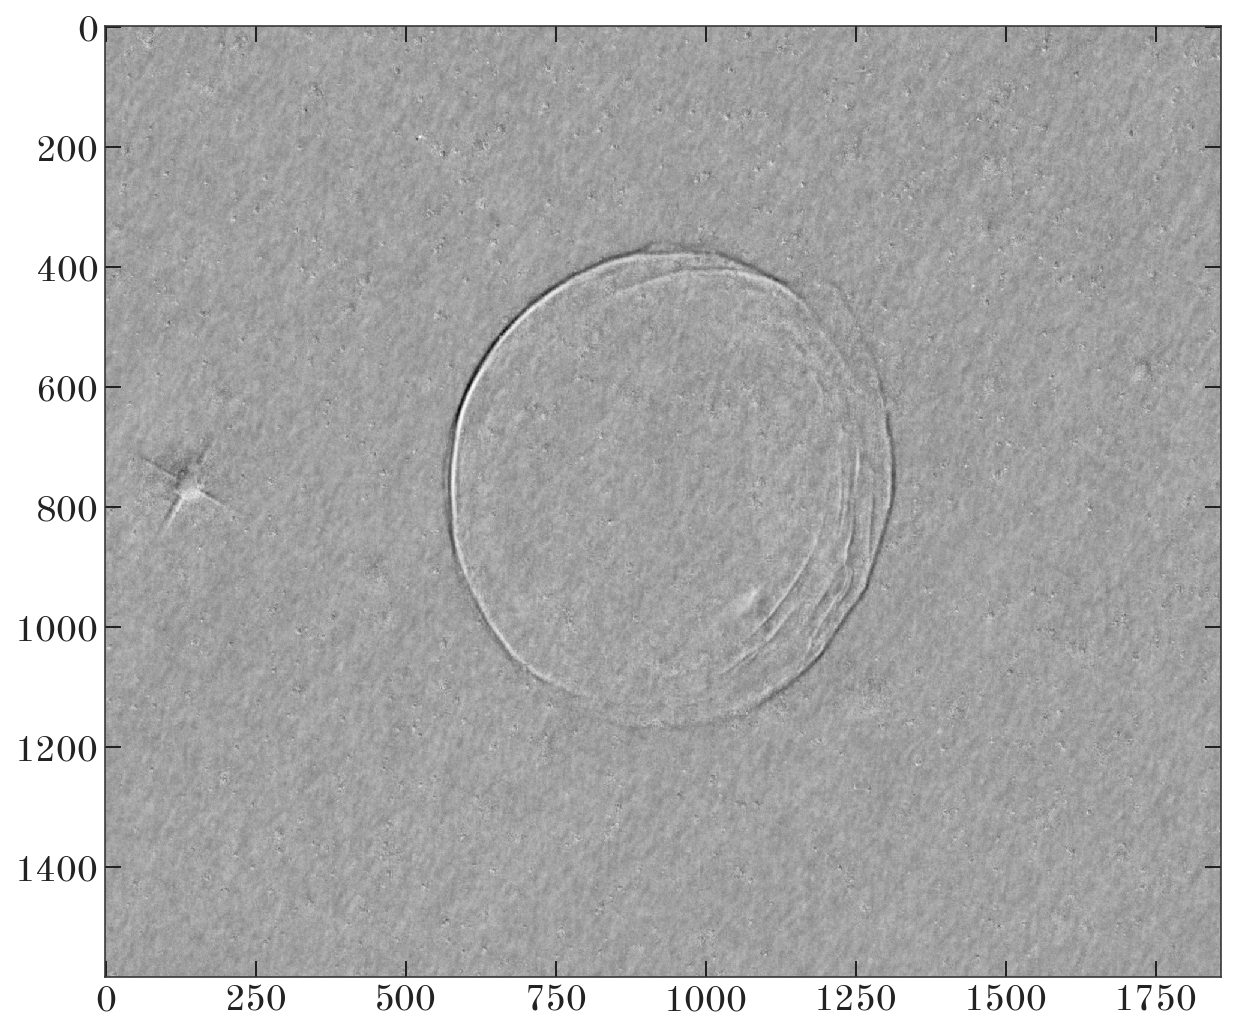

In [90]:
plt.figure(figsize=(10, 10))
plt.imshow(ifft(amp1 * np.exp(1j * phase2)).real - rgbs[0][..., 0], cmap='Greys')
# plt.colorbar()

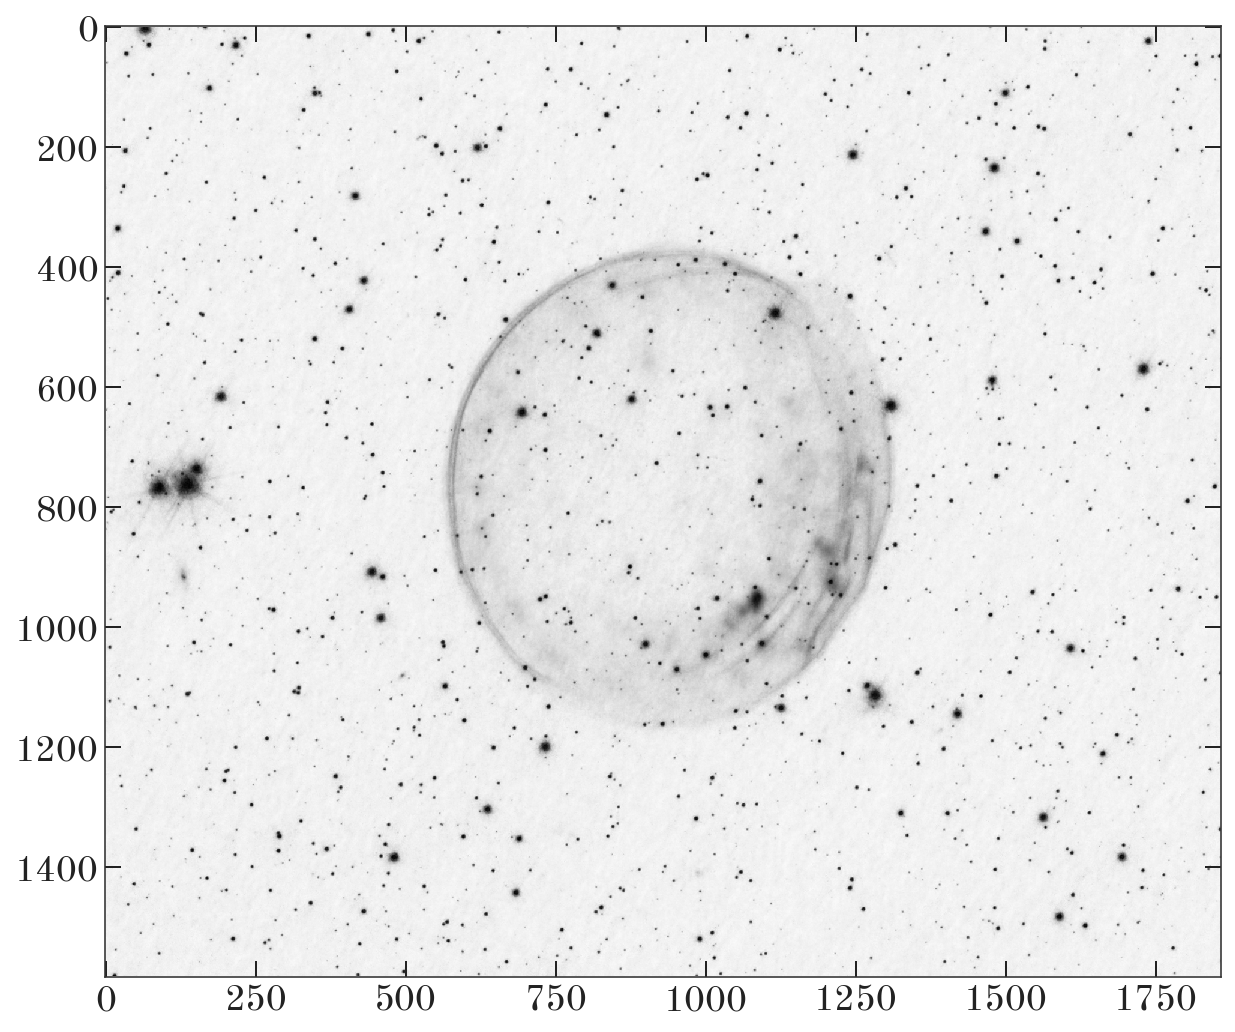

In [91]:
plt.figure(figsize=(10, 10))
plt.imshow(ifft(amp2 * np.exp(1j * phase1)).real, cmap='Greys')

In [ ]:
fft(x, n=None, axis=-1, overwrite_x=0)¶


In [ ]:
(x, shape=None, axes=(-2, -1), overwrite_x=False)[source]¶